## Import Libraries

In [4]:
import gym
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from stockstats import StockDataFrame as Sdf
from finrl.agents.stablebaselines3.models import A2C

from finrl.agents.stablebaselines3.models import DummyVecEnv


## Importing local modules

In [5]:
import os
import sys
sys.path.append('../')
from src.rl_env.stock import SingleStockEnv
from src.models.models import RLModels
from src.data.make_dataset import download_stock_data

In [6]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Download and save the data in a pandas DataFrame:
data_df = download_stock_data("GOOGL", start_date="2009-01-01", end_date="2020-10-23")

[*********************100%***********************]  1 of 1 completed


In [8]:
data_df

,date,open,high,low,close,adjcp,volume
0,2009-01-02,7.722723,8.053554,7.645145,8.041041,8.041041,144275580
1,2009-01-05,8.033033,8.289289,7.882883,8.209459,8.209459,195364440
2,2009-01-06,8.332833,8.528529,8.167918,8.359860,8.359860,256750992
3,2009-01-07,8.216216,8.281031,7.976727,8.058308,8.058308,179600220
4,2009-01-08,7.964965,8.137888,7.941441,8.137888,8.137888,143883972
...,...,...,...,...,...,...,...
2968,2020-10-16,78.091499,78.885498,77.883003,78.385002,78.385002,34194000
2969,2020-10-19,78.796501,79.196503,76.146004,76.497498,76.497498,29734000
2970,2020-10-20,76.155502,78.692001,76.025002,77.554001,77.554001,41670000
2971,2020-10-21,78.492500,80.757004,78.357002,79.299500,79.299500,60322000


In [9]:
data_clean = data_df.copy()

In [10]:
data_clean

,date,open,high,low,close,adjcp,volume
0,2009-01-02,7.722723,8.053554,7.645145,8.041041,8.041041,144275580
1,2009-01-05,8.033033,8.289289,7.882883,8.209459,8.209459,195364440
2,2009-01-06,8.332833,8.528529,8.167918,8.359860,8.359860,256750992
3,2009-01-07,8.216216,8.281031,7.976727,8.058308,8.058308,179600220
4,2009-01-08,7.964965,8.137888,7.941441,8.137888,8.137888,143883972
...,...,...,...,...,...,...,...
2968,2020-10-16,78.091499,78.885498,77.883003,78.385002,78.385002,34194000
2969,2020-10-19,78.796501,79.196503,76.146004,76.497498,76.497498,29734000
2970,2020-10-20,76.155502,78.692001,76.025002,77.554001,77.554001,41670000
2971,2020-10-21,78.492500,80.757004,78.357002,79.299500,79.299500,60322000


In [11]:
train = data_clean[(data_clean.date>='2009-01-01') & (data_clean.date<'2019-01-01')]
# the index needs to start from 0
train=train.reset_index(drop=True)


In [22]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

# Global variables
HMAX_NORMALIZE = 200
INITIAL_ACCOUNT_BALANCE=100000
STOCK_DIM = 1

# transaction fee: 1/1000 reasonable percentage
TRANSACTION_FEE_PERCENT = 0.001
# REWARD_SCALING = 1e-3


class SingleStockEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df,day = 0, feat_list = []):
        #super(StockEnv, self).__init__()
        # date increment
        self.feat_list = feat_list
        self.day = day
        self.df = df
        # action_space normalization and the shape is STOCK_DIM
        self.action_space = spaces.Box(low = -1, high = 1,shape = (STOCK_DIM,)) 
        # Shape = 1+1+len(features) 
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (1+1+1+len(self.feat_list),))
        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        # termination
        self.terminal = False  
        # save the total number of trades
        self.trades = 0
        # initalize state
        
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                    [self.data.adjcp] + \
                      [0]*STOCK_DIM + \
                      [self.data[feat] for feat in self.feat_list]
        # initialize reward and cost
        self.reward = 0
        self.cost = 0
        
        # memorize the total value, total rewards
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.rewards_memory = []

    def _sell_stock(self, index, action):
        # perform sell action based on the sign of the action
        if self.state[index+STOCK_DIM+1] > 0:
            # update balance
            self.state[0] += \
            self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             (1- TRANSACTION_FEE_PERCENT)
            # update held shares
            self.state[index+STOCK_DIM+1] -= min(abs(action), self.state[index+STOCK_DIM+1])
            # update transaction costs
            self.cost +=self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             TRANSACTION_FEE_PERCENT
            self.trades+=1
        else:
            pass
            
    def _buy_stock(self, index, action):
        # perform buy action based on the sign of the action
        available_amount = self.state[0] // self.state[index+1]
        #update balance
        self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                          (1+ TRANSACTION_FEE_PERCENT)
        # update held shares
        self.state[index+STOCK_DIM+1] += min(available_amount, action)
        # update transaction costs
        self.cost+=self.state[index+1]*min(available_amount, action)* \
                          TRANSACTION_FEE_PERCENT
        self.trades+=1
        
    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique())-1

        if self.terminal:
            plt.plot(self.asset_memory,'r')
            plt.savefig('account_value.png')
            plt.close()
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            print("previous_total_asset:{}".format(self.asset_memory[0])) 
            print("end_total_asset:{}".format(end_total_asset))
            
            df_total_value = pd.DataFrame(self.asset_memory)
            df_total_value.to_csv('account_value.csv')
            print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))- INITIAL_ACCOUNT_BALANCE ))
            print("total_cost: ", self.cost)
            print("total trades: ", self.trades)
            
            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            
            if df_total_value['daily_return'].std()!=0:
                sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
                      df_total_value['daily_return'].std()
                print("Sharpe: ",sharpe)
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.to_csv('account_rewards.csv')
            return self.state, self.reward, self.terminal,{}

        else:
            
            # actions are the shares we need to buy, hold, or sell
            actions = actions * HMAX_NORMALIZE
            # calculate begining total asset
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            
            # perform buy or sell action
            argsort_actions = np.argsort(actions)
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print('take sell action'.format(actions[index]))
                self._sell_stock(index, actions[index])

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                self._buy_stock(index, actions[index])
            
            # update data, walk a step s'
            self.day += 1
            self.data = self.df.loc[self.day,:]         
            #load next state
            self.state =  [self.state[0]] + \
                          [self.data.adjcp] + \
                          list(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]) +\
                          [self.data[feat] for feat in self.feat_list]
                        
            # calculate the end total asset
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            self.reward = end_total_asset - begin_total_asset  
            self.rewards_memory.append(self.reward)
            #self.reward = self.reward * REWARD_SCALING
            self.asset_memory.append(end_total_asset)

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        self.rewards_memory = []
        #initiate state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      [self.data.adjcp] + \
                      [0]*STOCK_DIM + [self.data[feat] for feat in self.feat_list]
       
        return self.state
    
    def render(self, mode='human'):
        return self.state

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


In [24]:
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model = RLModels('a2c', env_train)
model.train(total_timesteps=100000)
model.save('AAPL_ppo_100k')


previous_total_asset:100000
end_total_asset:99915.24691385136
total_reward:-84.7530861486448
total_cost:  71.24190593658248
total trades:  107
Sharpe:  -0.0323265885804657
previous_total_asset:100000
end_total_asset:158094.55245582713
total_reward:58094.55245582713
total_cost:  6565.01958954711
total trades:  2052
Sharpe:  0.3860402493175484
previous_total_asset:100000
end_total_asset:436625.8825829471
total_reward:336625.8825829471
total_cost:  5190.878990060563
total trades:  2514
Sharpe:  0.7859144168401349
previous_total_asset:100000
end_total_asset:203213.65780914135
total_reward:103213.65780914135
total_cost:  7800.308150769737
total trades:  2479
Sharpe:  0.5316009907518962
previous_total_asset:100000
end_total_asset:443601.9600015371
total_reward:343601.9600015371
total_cost:  7783.838933673102
total trades:  2514
Sharpe:  0.7797339239005414
previous_total_asset:100000
end_total_asset:558291.7644602383
total_reward:458291.7644602383
total_cost:  7637.982524972812
total trades: 

In [25]:
test = data_clean[(data_clean.date>='2019-01-01') ]
# the index needs to start from 0
test=test.reset_index(drop=True)

In [27]:
model = model
env_test = DummyVecEnv([lambda: SingleStockEnv(test,)])
obs_test = env_test.reset()
print("==============Model Prediction===========")
for i in range(len(test.index.unique())):
    action, _states = model.predict(obs_test)
    obs_test, rewards, dones, info = env_test.step(action)
    env_test.render()

==============Model Prediction===========
previous_total_asset:100000
end_total_asset:142931.3590275732
total_reward:42931.3590275732
total_cost:  4923.378802244765
total trades:  456
Sharpe:  0.7966023159998361


In [28]:
def get_DRL_sharpe():
    df_total_value=pd.read_csv('account_value.csv',index_col=0)
    df_total_value.columns = ['account_value']
    df_total_value['daily_return']=df_total_value.pct_change(1)
    sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
    df_total_value['daily_return'].std()
    
    annual_return = ((df_total_value['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)
    print("sharpe ratio: ", sharpe)
    return df_total_value

In [29]:
df_total_value=pd.read_csv('account_value.csv',index_col=0)
df_total_value.columns = ['account_value']
df_total_value['daily_return']=df_total_value.pct_change(1)

In [30]:
df_total_value['daily_return'].mean()

0.0009712109921866692

In [31]:


def get_buy_and_hold_sharpe(test):
    test['daily_return']=test['adjcp'].pct_change(1)
    sharpe = (252**0.5)*test['daily_return'].mean()/ \
    test['daily_return'].std()
    annual_return = ((test['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)

    print("sharpe ratio: ", sharpe)
    #return sharpe



In [32]:
df_total_value=get_DRL_sharpe()

annual return:  27.714407962105646
sharpe ratio:  0.796602315999837


In [33]:
get_buy_and_hold_sharpe(test)

annual return:  32.96312299591686
sharpe ratio:  0.8814613447586216


In [34]:
DRL_cumulative_return = (df_total_value.account_value.pct_change(1)+1).cumprod()-1

In [35]:
buy_and_hold_cumulative_return = (test.adjcp.pct_change(1)+1).cumprod()-1

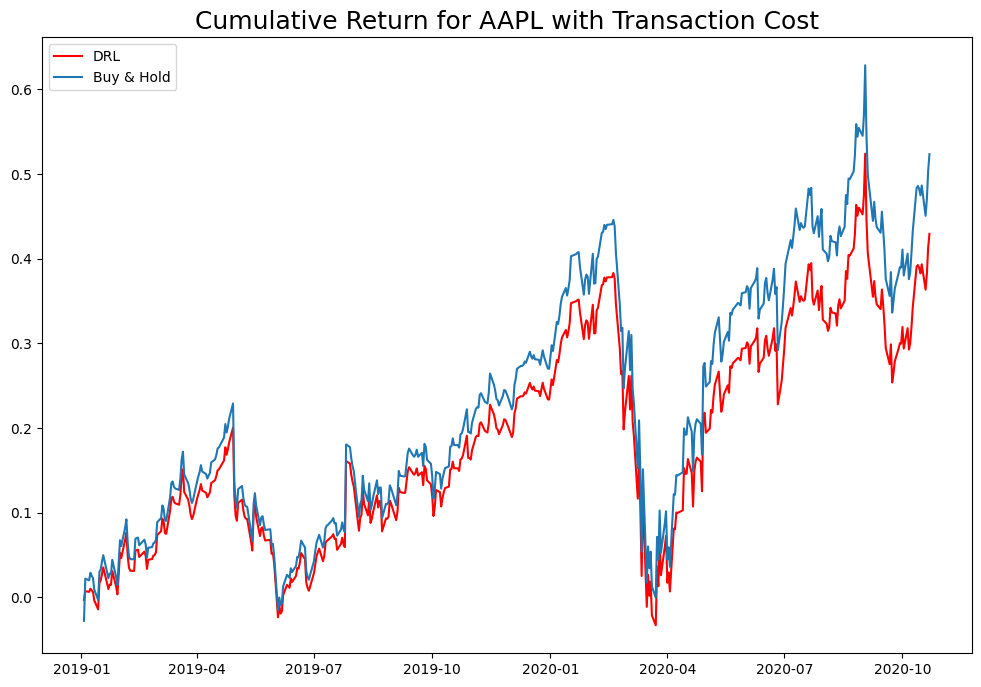

In [36]:


%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(test.date, DRL_cumulative_return, color='red',label = "DRL")
plt.plot(test.date, buy_and_hold_cumulative_return, label = "Buy & Hold")
plt.title("Cumulative Return for AAPL with Transaction Cost",size= 18)
plt.legend()
plt.rc('legend',fontsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

